In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [2]:
torch.manual_seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [3]:
# dataset prep
batch_size = 128

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        ])
train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('mnist_data', train=False, download=True, transform=transform)

training_DataLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testing_DataLoader= DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [4]:
class DynamicDNNModel(nn.Module):
  def __init__(self, start_num):
    super(DynamicDNNModel, self).__init__()
    self.Dense1 = nn.Linear(28*28, start_num)
    self.Dense2 = nn.Linear(start_num, start_num*3)
    self.Dense3 = nn.Linear(start_num*3, start_num*6)
    self.Dense4 = nn.Linear(start_num*6, 10)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.Dense1(x)
    x = self.Dense2(x)
    x = self.Dense3(x)
    x = self.Dense4(x)
    out = F.log_softmax(x, dim=1)
    return out

In [5]:

def train(model, optimizer, train_loader):
    model.train()
    loss_func = torch.nn.CrossEntropyLoss()
    correct = 0
    total_samples = 0
    batch_loss=[]

    for i, batch in tqdm(enumerate(train_loader)):
        images, labels = batch[0].to(device), batch[1].to(device)
        # Forward pass
        output = model(images)
        loss = loss_func(output, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        predicted = torch.max(output.data, 1)[1]
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        batch_loss.append(loss.item())

    # Calculate average loss
    train_loss = sum(batch_loss) / len(train_loader.dataset)

    acc = 100. * correct / total_samples
    return train_loss, acc

In [6]:
def test(model, test_loader):
    model.eval()
    test_losses = []
    loss_func = torch.nn.CrossEntropyLoss()
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            output = model(images)
            loss = loss_func(output, labels)
            test_losses.append(loss.item())

            _, pred = torch.max(output, 1)
            correct += (pred == labels).sum().item()
            total_samples += labels.size(0)


    # Calculate average loss
    test_loss = sum(test_losses) / len(test_loader.dataset)

    # Calculate accuracy
    accuracy = 100. * correct / total_samples


    return test_loss, accuracy

In [7]:
epochs = 15
train_loss_arr = []
test_loss_arr = []
train_acc_arr = []
test_acc_arr = []
params_arr = []

for model_count, param_count in enumerate(list(map(lambda x : x*9, range(1,11)))):
    model = DynamicDNNModel(param_count).to(device)
    params_arr.append(sum(p.numel() for p in model.parameters() if p.requires_grad))
    optimizer1 = optim.Adam(model.parameters(), lr=1e-4)
    cur_train_loss = []
    cur_test_loss = []
    cur_train_acc = []
    cur_test_acc = []
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer1, training_DataLoader)
        test_loss, test_acc = test(model, testing_DataLoader)

        print(f'Model - {model_count} :: Epoch - {epoch} Train Loss - {train_loss:.6f} Test Loss - {test_loss:.6f} Train Accuracy - {train_acc:.6f} Test Accuracy - {test_acc:.6f}')

        cur_train_loss.append(train_loss)
        cur_test_loss.append(test_loss)
        cur_train_acc.append(train_acc)
        cur_test_acc.append(test_acc)
    train_loss_arr.append(np.mean(cur_train_loss))
    test_loss_arr.append(np.mean(cur_test_loss))
    train_acc_arr.append(np.mean(cur_train_acc))
    test_acc_arr.append(np.mean(cur_test_acc))

469it [00:13, 35.41it/s]


Model - 0 :: Epoch - 0 Train Loss - 0.010514 Test Loss - 0.005220 Train Accuracy - 61.811667 Test Accuracy - 80.740000


469it [00:12, 36.16it/s]


Model - 0 :: Epoch - 1 Train Loss - 0.004246 Test Loss - 0.003545 Train Accuracy - 83.920000 Test Accuracy - 86.760000


469it [00:12, 36.46it/s]


Model - 0 :: Epoch - 2 Train Loss - 0.003286 Test Loss - 0.002969 Train Accuracy - 87.840000 Test Accuracy - 89.460000


469it [00:12, 36.90it/s]


Model - 0 :: Epoch - 3 Train Loss - 0.002848 Test Loss - 0.002622 Train Accuracy - 89.535000 Test Accuracy - 90.480000


469it [00:12, 36.86it/s]


Model - 0 :: Epoch - 4 Train Loss - 0.002626 Test Loss - 0.002480 Train Accuracy - 90.376667 Test Accuracy - 90.860000


469it [00:12, 36.31it/s]


Model - 0 :: Epoch - 5 Train Loss - 0.002499 Test Loss - 0.002516 Train Accuracy - 90.830000 Test Accuracy - 91.120000


469it [00:12, 36.27it/s]


Model - 0 :: Epoch - 6 Train Loss - 0.002420 Test Loss - 0.002348 Train Accuracy - 91.148333 Test Accuracy - 91.330000


469it [00:12, 36.81it/s]


Model - 0 :: Epoch - 7 Train Loss - 0.002362 Test Loss - 0.002319 Train Accuracy - 91.345000 Test Accuracy - 91.470000


469it [00:14, 32.97it/s]


Model - 0 :: Epoch - 8 Train Loss - 0.002321 Test Loss - 0.002287 Train Accuracy - 91.510000 Test Accuracy - 91.670000


469it [00:13, 34.69it/s]


Model - 0 :: Epoch - 9 Train Loss - 0.002287 Test Loss - 0.002268 Train Accuracy - 91.651667 Test Accuracy - 91.680000


469it [00:12, 36.21it/s]


Model - 0 :: Epoch - 10 Train Loss - 0.002258 Test Loss - 0.002273 Train Accuracy - 91.843333 Test Accuracy - 91.720000


469it [00:12, 36.53it/s]


Model - 0 :: Epoch - 11 Train Loss - 0.002235 Test Loss - 0.002291 Train Accuracy - 91.918333 Test Accuracy - 91.880000


469it [00:12, 36.81it/s]


Model - 0 :: Epoch - 12 Train Loss - 0.002216 Test Loss - 0.002299 Train Accuracy - 92.020000 Test Accuracy - 91.940000


469it [00:14, 32.61it/s]


Model - 0 :: Epoch - 13 Train Loss - 0.002196 Test Loss - 0.002205 Train Accuracy - 92.096667 Test Accuracy - 92.040000


469it [00:15, 29.95it/s]


Model - 0 :: Epoch - 14 Train Loss - 0.002178 Test Loss - 0.002206 Train Accuracy - 92.158333 Test Accuracy - 92.000000


469it [00:15, 30.41it/s]


Model - 1 :: Epoch - 0 Train Loss - 0.007851 Test Loss - 0.003345 Train Accuracy - 74.540000 Test Accuracy - 88.240000


469it [00:15, 31.22it/s]


Model - 1 :: Epoch - 1 Train Loss - 0.003009 Test Loss - 0.002617 Train Accuracy - 89.040000 Test Accuracy - 90.690000


469it [00:12, 36.85it/s]


Model - 1 :: Epoch - 2 Train Loss - 0.002577 Test Loss - 0.002390 Train Accuracy - 90.541667 Test Accuracy - 91.490000


469it [00:12, 36.34it/s]


Model - 1 :: Epoch - 3 Train Loss - 0.002396 Test Loss - 0.002265 Train Accuracy - 91.246667 Test Accuracy - 91.770000


469it [00:12, 36.39it/s]


Model - 1 :: Epoch - 4 Train Loss - 0.002299 Test Loss - 0.002223 Train Accuracy - 91.676667 Test Accuracy - 91.780000


469it [00:12, 36.98it/s]


Model - 1 :: Epoch - 5 Train Loss - 0.002238 Test Loss - 0.002175 Train Accuracy - 91.846667 Test Accuracy - 92.090000


469it [00:12, 36.64it/s]


Model - 1 :: Epoch - 6 Train Loss - 0.002196 Test Loss - 0.002171 Train Accuracy - 92.091667 Test Accuracy - 92.160000


469it [00:14, 31.78it/s]


Model - 1 :: Epoch - 7 Train Loss - 0.002164 Test Loss - 0.002161 Train Accuracy - 92.165000 Test Accuracy - 92.090000


469it [00:14, 31.80it/s]


Model - 1 :: Epoch - 8 Train Loss - 0.002138 Test Loss - 0.002153 Train Accuracy - 92.296667 Test Accuracy - 92.120000


469it [00:12, 36.98it/s]


Model - 1 :: Epoch - 9 Train Loss - 0.002117 Test Loss - 0.002129 Train Accuracy - 92.381667 Test Accuracy - 92.360000


469it [00:12, 36.24it/s]


Model - 1 :: Epoch - 10 Train Loss - 0.002100 Test Loss - 0.002155 Train Accuracy - 92.486667 Test Accuracy - 92.520000


469it [00:12, 36.30it/s]


Model - 1 :: Epoch - 11 Train Loss - 0.002085 Test Loss - 0.002130 Train Accuracy - 92.515000 Test Accuracy - 92.270000


469it [00:12, 36.88it/s]


Model - 1 :: Epoch - 12 Train Loss - 0.002068 Test Loss - 0.002138 Train Accuracy - 92.593333 Test Accuracy - 92.300000


469it [00:12, 36.35it/s]


Model - 1 :: Epoch - 13 Train Loss - 0.002056 Test Loss - 0.002117 Train Accuracy - 92.663333 Test Accuracy - 92.390000


469it [00:12, 36.89it/s]


Model - 1 :: Epoch - 14 Train Loss - 0.002042 Test Loss - 0.002101 Train Accuracy - 92.730000 Test Accuracy - 92.470000


469it [00:13, 35.21it/s]


Model - 2 :: Epoch - 0 Train Loss - 0.006741 Test Loss - 0.002993 Train Accuracy - 75.838333 Test Accuracy - 89.170000


469it [00:12, 36.32it/s]


Model - 2 :: Epoch - 1 Train Loss - 0.002720 Test Loss - 0.002430 Train Accuracy - 89.948333 Test Accuracy - 90.530000


469it [00:12, 36.45it/s]


Model - 2 :: Epoch - 2 Train Loss - 0.002414 Test Loss - 0.002321 Train Accuracy - 91.130000 Test Accuracy - 91.570000


469it [00:13, 36.04it/s]


Model - 2 :: Epoch - 3 Train Loss - 0.002293 Test Loss - 0.002217 Train Accuracy - 91.656667 Test Accuracy - 91.660000


469it [00:12, 36.86it/s]


Model - 2 :: Epoch - 4 Train Loss - 0.002225 Test Loss - 0.002179 Train Accuracy - 91.956667 Test Accuracy - 91.920000


469it [00:13, 34.29it/s]


Model - 2 :: Epoch - 5 Train Loss - 0.002179 Test Loss - 0.002225 Train Accuracy - 92.128333 Test Accuracy - 91.940000


469it [00:14, 32.85it/s]


Model - 2 :: Epoch - 6 Train Loss - 0.002148 Test Loss - 0.002191 Train Accuracy - 92.285000 Test Accuracy - 92.120000


469it [00:14, 33.01it/s]


Model - 2 :: Epoch - 7 Train Loss - 0.002120 Test Loss - 0.002159 Train Accuracy - 92.388333 Test Accuracy - 92.210000


469it [00:14, 33.24it/s]


Model - 2 :: Epoch - 8 Train Loss - 0.002101 Test Loss - 0.002120 Train Accuracy - 92.438333 Test Accuracy - 92.230000


469it [00:12, 36.72it/s]


Model - 2 :: Epoch - 9 Train Loss - 0.002078 Test Loss - 0.002150 Train Accuracy - 92.623333 Test Accuracy - 92.270000


469it [00:12, 36.73it/s]


Model - 2 :: Epoch - 10 Train Loss - 0.002063 Test Loss - 0.002124 Train Accuracy - 92.650000 Test Accuracy - 92.400000


469it [00:12, 36.28it/s]


Model - 2 :: Epoch - 11 Train Loss - 0.002048 Test Loss - 0.002109 Train Accuracy - 92.716667 Test Accuracy - 92.370000


469it [00:12, 36.58it/s]


Model - 2 :: Epoch - 12 Train Loss - 0.002035 Test Loss - 0.002123 Train Accuracy - 92.766667 Test Accuracy - 92.510000


469it [00:15, 30.68it/s]


Model - 2 :: Epoch - 13 Train Loss - 0.002025 Test Loss - 0.002156 Train Accuracy - 92.766667 Test Accuracy - 92.500000


469it [00:15, 29.82it/s]


Model - 2 :: Epoch - 14 Train Loss - 0.002014 Test Loss - 0.002124 Train Accuracy - 92.803333 Test Accuracy - 92.480000


469it [00:12, 36.99it/s]


Model - 3 :: Epoch - 0 Train Loss - 0.005965 Test Loss - 0.002831 Train Accuracy - 80.225000 Test Accuracy - 89.970000


469it [00:14, 31.34it/s]


Model - 3 :: Epoch - 1 Train Loss - 0.002611 Test Loss - 0.002400 Train Accuracy - 90.491667 Test Accuracy - 91.460000


469it [00:15, 30.68it/s]


Model - 3 :: Epoch - 2 Train Loss - 0.002356 Test Loss - 0.002257 Train Accuracy - 91.376667 Test Accuracy - 91.800000


469it [00:14, 31.30it/s]


Model - 3 :: Epoch - 3 Train Loss - 0.002259 Test Loss - 0.002197 Train Accuracy - 91.753333 Test Accuracy - 91.780000


469it [00:12, 36.81it/s]


Model - 3 :: Epoch - 4 Train Loss - 0.002193 Test Loss - 0.002220 Train Accuracy - 92.098333 Test Accuracy - 91.910000


469it [00:12, 36.86it/s]


Model - 3 :: Epoch - 5 Train Loss - 0.002158 Test Loss - 0.002142 Train Accuracy - 92.231667 Test Accuracy - 92.170000


469it [00:12, 36.35it/s]


Model - 3 :: Epoch - 6 Train Loss - 0.002127 Test Loss - 0.002157 Train Accuracy - 92.326667 Test Accuracy - 92.240000


469it [00:12, 36.39it/s]


Model - 3 :: Epoch - 7 Train Loss - 0.002102 Test Loss - 0.002154 Train Accuracy - 92.410000 Test Accuracy - 92.390000


469it [00:12, 37.04it/s]


Model - 3 :: Epoch - 8 Train Loss - 0.002083 Test Loss - 0.002133 Train Accuracy - 92.541667 Test Accuracy - 92.380000


469it [00:15, 30.61it/s]


Model - 3 :: Epoch - 9 Train Loss - 0.002068 Test Loss - 0.002189 Train Accuracy - 92.693333 Test Accuracy - 92.140000


469it [00:15, 30.35it/s]


Model - 3 :: Epoch - 10 Train Loss - 0.002053 Test Loss - 0.002128 Train Accuracy - 92.625000 Test Accuracy - 92.520000


469it [00:13, 35.95it/s]


Model - 3 :: Epoch - 11 Train Loss - 0.002036 Test Loss - 0.002133 Train Accuracy - 92.673333 Test Accuracy - 92.360000


469it [00:12, 36.14it/s]


Model - 3 :: Epoch - 12 Train Loss - 0.002027 Test Loss - 0.002122 Train Accuracy - 92.801667 Test Accuracy - 92.330000


469it [00:12, 36.22it/s]


Model - 3 :: Epoch - 13 Train Loss - 0.002012 Test Loss - 0.002140 Train Accuracy - 92.848333 Test Accuracy - 92.110000


469it [00:13, 36.06it/s]


Model - 3 :: Epoch - 14 Train Loss - 0.002004 Test Loss - 0.002167 Train Accuracy - 92.891667 Test Accuracy - 92.280000


469it [00:13, 34.10it/s]


Model - 4 :: Epoch - 0 Train Loss - 0.005489 Test Loss - 0.002676 Train Accuracy - 81.566667 Test Accuracy - 90.440000


469it [00:12, 36.75it/s]


Model - 4 :: Epoch - 1 Train Loss - 0.002523 Test Loss - 0.002375 Train Accuracy - 90.698333 Test Accuracy - 91.700000


469it [00:14, 32.88it/s]


Model - 4 :: Epoch - 2 Train Loss - 0.002324 Test Loss - 0.002219 Train Accuracy - 91.486667 Test Accuracy - 91.900000


469it [00:13, 34.19it/s]


Model - 4 :: Epoch - 3 Train Loss - 0.002241 Test Loss - 0.002207 Train Accuracy - 91.836667 Test Accuracy - 92.090000


469it [00:12, 36.35it/s]


Model - 4 :: Epoch - 4 Train Loss - 0.002186 Test Loss - 0.002172 Train Accuracy - 92.083333 Test Accuracy - 92.240000


469it [00:15, 30.75it/s]


Model - 4 :: Epoch - 5 Train Loss - 0.002151 Test Loss - 0.002166 Train Accuracy - 92.275000 Test Accuracy - 92.290000


469it [00:15, 29.84it/s]


Model - 4 :: Epoch - 6 Train Loss - 0.002120 Test Loss - 0.002194 Train Accuracy - 92.373333 Test Accuracy - 92.290000


469it [00:15, 30.91it/s]


Model - 4 :: Epoch - 7 Train Loss - 0.002100 Test Loss - 0.002193 Train Accuracy - 92.480000 Test Accuracy - 91.850000


469it [00:12, 37.08it/s]


Model - 4 :: Epoch - 8 Train Loss - 0.002072 Test Loss - 0.002116 Train Accuracy - 92.576667 Test Accuracy - 92.390000


469it [00:14, 32.17it/s]


Model - 4 :: Epoch - 9 Train Loss - 0.002061 Test Loss - 0.002127 Train Accuracy - 92.585000 Test Accuracy - 92.500000


469it [00:14, 33.15it/s]


Model - 4 :: Epoch - 10 Train Loss - 0.002046 Test Loss - 0.002157 Train Accuracy - 92.731667 Test Accuracy - 92.070000


469it [00:13, 36.02it/s]


Model - 4 :: Epoch - 11 Train Loss - 0.002034 Test Loss - 0.002138 Train Accuracy - 92.741667 Test Accuracy - 92.410000


469it [00:12, 36.64it/s]


Model - 4 :: Epoch - 12 Train Loss - 0.002022 Test Loss - 0.002182 Train Accuracy - 92.875000 Test Accuracy - 92.320000


469it [00:12, 36.39it/s]


Model - 4 :: Epoch - 13 Train Loss - 0.002012 Test Loss - 0.002105 Train Accuracy - 92.815000 Test Accuracy - 92.460000


469it [00:12, 36.21it/s]


Model - 4 :: Epoch - 14 Train Loss - 0.002004 Test Loss - 0.002134 Train Accuracy - 92.863333 Test Accuracy - 92.390000


469it [00:12, 36.79it/s]


Model - 5 :: Epoch - 0 Train Loss - 0.005174 Test Loss - 0.002521 Train Accuracy - 83.238333 Test Accuracy - 90.910000


469it [00:12, 36.62it/s]


Model - 5 :: Epoch - 1 Train Loss - 0.002472 Test Loss - 0.002368 Train Accuracy - 90.825000 Test Accuracy - 91.510000


469it [00:13, 36.05it/s]


Model - 5 :: Epoch - 2 Train Loss - 0.002306 Test Loss - 0.002257 Train Accuracy - 91.540000 Test Accuracy - 91.860000


469it [00:12, 36.30it/s]


Model - 5 :: Epoch - 3 Train Loss - 0.002219 Test Loss - 0.002176 Train Accuracy - 91.936667 Test Accuracy - 92.200000


469it [00:12, 36.13it/s]


Model - 5 :: Epoch - 4 Train Loss - 0.002175 Test Loss - 0.002165 Train Accuracy - 92.070000 Test Accuracy - 91.790000


469it [00:13, 36.01it/s]


Model - 5 :: Epoch - 5 Train Loss - 0.002138 Test Loss - 0.002182 Train Accuracy - 92.250000 Test Accuracy - 92.300000


469it [00:12, 36.74it/s]


Model - 5 :: Epoch - 6 Train Loss - 0.002114 Test Loss - 0.002155 Train Accuracy - 92.360000 Test Accuracy - 92.190000


469it [00:12, 36.95it/s]


Model - 5 :: Epoch - 7 Train Loss - 0.002093 Test Loss - 0.002150 Train Accuracy - 92.496667 Test Accuracy - 92.200000


469it [00:12, 36.93it/s]


Model - 5 :: Epoch - 8 Train Loss - 0.002072 Test Loss - 0.002105 Train Accuracy - 92.543333 Test Accuracy - 92.460000


469it [00:12, 36.77it/s]


Model - 5 :: Epoch - 9 Train Loss - 0.002051 Test Loss - 0.002152 Train Accuracy - 92.716667 Test Accuracy - 92.200000


469it [00:14, 31.49it/s]


Model - 5 :: Epoch - 10 Train Loss - 0.002038 Test Loss - 0.002154 Train Accuracy - 92.758333 Test Accuracy - 92.360000


469it [00:13, 34.67it/s]


Model - 5 :: Epoch - 11 Train Loss - 0.002027 Test Loss - 0.002167 Train Accuracy - 92.723333 Test Accuracy - 92.600000


469it [00:12, 36.33it/s]


Model - 5 :: Epoch - 12 Train Loss - 0.002013 Test Loss - 0.002177 Train Accuracy - 92.790000 Test Accuracy - 92.560000


469it [00:12, 36.92it/s]


Model - 5 :: Epoch - 13 Train Loss - 0.002003 Test Loss - 0.002089 Train Accuracy - 92.871667 Test Accuracy - 92.750000


469it [00:12, 37.02it/s]


Model - 5 :: Epoch - 14 Train Loss - 0.001999 Test Loss - 0.002096 Train Accuracy - 92.851667 Test Accuracy - 92.460000


469it [00:12, 37.04it/s]


Model - 6 :: Epoch - 0 Train Loss - 0.004917 Test Loss - 0.002564 Train Accuracy - 83.435000 Test Accuracy - 90.660000


469it [00:12, 36.34it/s]


Model - 6 :: Epoch - 1 Train Loss - 0.002445 Test Loss - 0.002251 Train Accuracy - 90.876667 Test Accuracy - 91.820000


469it [00:12, 36.35it/s]


Model - 6 :: Epoch - 2 Train Loss - 0.002289 Test Loss - 0.002197 Train Accuracy - 91.611667 Test Accuracy - 92.020000


469it [00:12, 36.50it/s]


Model - 6 :: Epoch - 3 Train Loss - 0.002216 Test Loss - 0.002212 Train Accuracy - 91.941667 Test Accuracy - 92.160000


469it [00:12, 36.26it/s]


Model - 6 :: Epoch - 4 Train Loss - 0.002164 Test Loss - 0.002167 Train Accuracy - 92.100000 Test Accuracy - 92.240000


469it [00:12, 36.18it/s]


Model - 6 :: Epoch - 5 Train Loss - 0.002131 Test Loss - 0.002166 Train Accuracy - 92.331667 Test Accuracy - 92.210000


469it [00:12, 36.54it/s]


Model - 6 :: Epoch - 6 Train Loss - 0.002105 Test Loss - 0.002133 Train Accuracy - 92.431667 Test Accuracy - 92.220000


469it [00:12, 36.38it/s]


Model - 6 :: Epoch - 7 Train Loss - 0.002085 Test Loss - 0.002180 Train Accuracy - 92.526667 Test Accuracy - 92.200000


469it [00:12, 37.01it/s]


Model - 6 :: Epoch - 8 Train Loss - 0.002066 Test Loss - 0.002113 Train Accuracy - 92.576667 Test Accuracy - 92.310000


469it [00:13, 36.00it/s]


Model - 6 :: Epoch - 9 Train Loss - 0.002046 Test Loss - 0.002118 Train Accuracy - 92.610000 Test Accuracy - 92.350000


469it [00:12, 36.34it/s]


Model - 6 :: Epoch - 10 Train Loss - 0.002035 Test Loss - 0.002156 Train Accuracy - 92.721667 Test Accuracy - 92.380000


469it [00:12, 36.48it/s]


Model - 6 :: Epoch - 11 Train Loss - 0.002021 Test Loss - 0.002115 Train Accuracy - 92.775000 Test Accuracy - 92.370000


469it [00:12, 36.78it/s]


Model - 6 :: Epoch - 12 Train Loss - 0.002016 Test Loss - 0.002170 Train Accuracy - 92.821667 Test Accuracy - 92.500000


469it [00:12, 36.68it/s]


Model - 6 :: Epoch - 13 Train Loss - 0.002000 Test Loss - 0.002104 Train Accuracy - 92.878333 Test Accuracy - 92.430000


469it [00:12, 36.20it/s]


Model - 6 :: Epoch - 14 Train Loss - 0.001994 Test Loss - 0.002170 Train Accuracy - 92.918333 Test Accuracy - 92.100000


469it [00:13, 35.99it/s]


Model - 7 :: Epoch - 0 Train Loss - 0.004735 Test Loss - 0.002501 Train Accuracy - 83.878333 Test Accuracy - 90.830000


469it [00:12, 36.43it/s]


Model - 7 :: Epoch - 1 Train Loss - 0.002424 Test Loss - 0.002280 Train Accuracy - 91.050000 Test Accuracy - 91.600000


469it [00:12, 36.73it/s]


Model - 7 :: Epoch - 2 Train Loss - 0.002276 Test Loss - 0.002214 Train Accuracy - 91.676667 Test Accuracy - 91.780000


469it [00:12, 36.81it/s]


Model - 7 :: Epoch - 3 Train Loss - 0.002201 Test Loss - 0.002183 Train Accuracy - 92.096667 Test Accuracy - 92.360000


469it [00:12, 36.35it/s]


Model - 7 :: Epoch - 4 Train Loss - 0.002158 Test Loss - 0.002187 Train Accuracy - 92.211667 Test Accuracy - 92.140000


469it [00:12, 36.38it/s]


Model - 7 :: Epoch - 5 Train Loss - 0.002125 Test Loss - 0.002135 Train Accuracy - 92.350000 Test Accuracy - 92.290000


469it [00:12, 36.64it/s]


Model - 7 :: Epoch - 6 Train Loss - 0.002093 Test Loss - 0.002110 Train Accuracy - 92.570000 Test Accuracy - 92.390000


469it [00:12, 36.49it/s]


Model - 7 :: Epoch - 7 Train Loss - 0.002072 Test Loss - 0.002139 Train Accuracy - 92.611667 Test Accuracy - 92.360000


469it [00:12, 36.64it/s]


Model - 7 :: Epoch - 8 Train Loss - 0.002059 Test Loss - 0.002152 Train Accuracy - 92.635000 Test Accuracy - 92.180000


469it [00:12, 37.02it/s]


Model - 7 :: Epoch - 9 Train Loss - 0.002037 Test Loss - 0.002152 Train Accuracy - 92.773333 Test Accuracy - 92.400000


469it [00:12, 36.81it/s]


Model - 7 :: Epoch - 10 Train Loss - 0.002031 Test Loss - 0.002147 Train Accuracy - 92.703333 Test Accuracy - 92.640000


469it [00:13, 34.70it/s]


Model - 7 :: Epoch - 11 Train Loss - 0.002023 Test Loss - 0.002134 Train Accuracy - 92.803333 Test Accuracy - 92.440000


469it [00:12, 36.60it/s]


Model - 7 :: Epoch - 12 Train Loss - 0.002011 Test Loss - 0.002095 Train Accuracy - 92.865000 Test Accuracy - 92.560000


469it [00:12, 36.70it/s]


Model - 7 :: Epoch - 13 Train Loss - 0.001996 Test Loss - 0.002101 Train Accuracy - 92.858333 Test Accuracy - 92.590000


469it [00:12, 36.26it/s]


Model - 7 :: Epoch - 14 Train Loss - 0.001988 Test Loss - 0.002120 Train Accuracy - 92.900000 Test Accuracy - 92.370000


469it [00:12, 36.24it/s]


Model - 8 :: Epoch - 0 Train Loss - 0.004464 Test Loss - 0.002439 Train Accuracy - 84.763333 Test Accuracy - 91.030000


469it [00:12, 36.88it/s]


Model - 8 :: Epoch - 1 Train Loss - 0.002395 Test Loss - 0.002262 Train Accuracy - 91.373333 Test Accuracy - 91.710000


469it [00:14, 33.06it/s]


Model - 8 :: Epoch - 2 Train Loss - 0.002266 Test Loss - 0.002238 Train Accuracy - 91.750000 Test Accuracy - 91.780000


469it [00:13, 35.12it/s]


Model - 8 :: Epoch - 3 Train Loss - 0.002203 Test Loss - 0.002192 Train Accuracy - 92.076667 Test Accuracy - 91.970000


469it [00:12, 36.15it/s]


Model - 8 :: Epoch - 4 Train Loss - 0.002154 Test Loss - 0.002174 Train Accuracy - 92.286667 Test Accuracy - 92.060000


469it [00:13, 35.95it/s]


Model - 8 :: Epoch - 5 Train Loss - 0.002120 Test Loss - 0.002210 Train Accuracy - 92.440000 Test Accuracy - 92.040000


469it [00:12, 36.21it/s]


Model - 8 :: Epoch - 6 Train Loss - 0.002094 Test Loss - 0.002159 Train Accuracy - 92.511667 Test Accuracy - 92.400000


469it [00:12, 36.20it/s]


Model - 8 :: Epoch - 7 Train Loss - 0.002083 Test Loss - 0.002185 Train Accuracy - 92.618333 Test Accuracy - 92.090000


469it [00:12, 36.52it/s]


Model - 8 :: Epoch - 8 Train Loss - 0.002062 Test Loss - 0.002164 Train Accuracy - 92.633333 Test Accuracy - 92.300000


469it [00:12, 36.88it/s]


Model - 8 :: Epoch - 9 Train Loss - 0.002046 Test Loss - 0.002124 Train Accuracy - 92.638333 Test Accuracy - 92.590000


469it [00:12, 36.89it/s]


Model - 8 :: Epoch - 10 Train Loss - 0.002035 Test Loss - 0.002130 Train Accuracy - 92.715000 Test Accuracy - 92.400000


469it [00:12, 36.18it/s]


Model - 8 :: Epoch - 11 Train Loss - 0.002024 Test Loss - 0.002129 Train Accuracy - 92.870000 Test Accuracy - 92.550000


469it [00:12, 36.38it/s]


Model - 8 :: Epoch - 12 Train Loss - 0.002012 Test Loss - 0.002135 Train Accuracy - 92.835000 Test Accuracy - 92.360000


469it [00:12, 36.87it/s]


Model - 8 :: Epoch - 13 Train Loss - 0.002001 Test Loss - 0.002160 Train Accuracy - 92.911667 Test Accuracy - 92.440000


469it [00:13, 36.06it/s]


Model - 8 :: Epoch - 14 Train Loss - 0.001985 Test Loss - 0.002146 Train Accuracy - 92.966667 Test Accuracy - 92.390000


469it [00:12, 36.09it/s]


Model - 9 :: Epoch - 0 Train Loss - 0.004378 Test Loss - 0.002402 Train Accuracy - 85.041667 Test Accuracy - 91.110000


469it [00:12, 36.63it/s]


Model - 9 :: Epoch - 1 Train Loss - 0.002389 Test Loss - 0.002232 Train Accuracy - 91.198333 Test Accuracy - 91.810000


469it [00:12, 36.15it/s]


Model - 9 :: Epoch - 2 Train Loss - 0.002261 Test Loss - 0.002314 Train Accuracy - 91.700000 Test Accuracy - 91.930000


469it [00:12, 36.35it/s]


Model - 9 :: Epoch - 3 Train Loss - 0.002198 Test Loss - 0.002150 Train Accuracy - 92.063333 Test Accuracy - 92.290000


469it [00:12, 36.78it/s]


Model - 9 :: Epoch - 4 Train Loss - 0.002153 Test Loss - 0.002164 Train Accuracy - 92.276667 Test Accuracy - 92.140000


469it [00:15, 30.19it/s]


Model - 9 :: Epoch - 5 Train Loss - 0.002126 Test Loss - 0.002202 Train Accuracy - 92.403333 Test Accuracy - 92.220000


469it [00:15, 31.03it/s]


Model - 9 :: Epoch - 6 Train Loss - 0.002096 Test Loss - 0.002157 Train Accuracy - 92.451667 Test Accuracy - 92.110000


469it [00:12, 36.97it/s]


Model - 9 :: Epoch - 7 Train Loss - 0.002075 Test Loss - 0.002195 Train Accuracy - 92.541667 Test Accuracy - 92.320000


469it [00:12, 36.93it/s]


Model - 9 :: Epoch - 8 Train Loss - 0.002064 Test Loss - 0.002107 Train Accuracy - 92.616667 Test Accuracy - 92.660000


469it [00:12, 36.44it/s]


Model - 9 :: Epoch - 9 Train Loss - 0.002047 Test Loss - 0.002198 Train Accuracy - 92.621667 Test Accuracy - 92.240000


469it [00:12, 36.88it/s]


Model - 9 :: Epoch - 10 Train Loss - 0.002037 Test Loss - 0.002192 Train Accuracy - 92.796667 Test Accuracy - 92.150000


469it [00:12, 36.70it/s]


Model - 9 :: Epoch - 11 Train Loss - 0.002020 Test Loss - 0.002133 Train Accuracy - 92.806667 Test Accuracy - 92.510000


469it [00:12, 36.58it/s]


Model - 9 :: Epoch - 12 Train Loss - 0.002013 Test Loss - 0.002132 Train Accuracy - 92.810000 Test Accuracy - 92.380000


469it [00:12, 36.81it/s]


Model - 9 :: Epoch - 13 Train Loss - 0.002001 Test Loss - 0.002138 Train Accuracy - 92.895000 Test Accuracy - 92.490000


469it [00:12, 37.46it/s]


Model - 9 :: Epoch - 14 Train Loss - 0.001995 Test Loss - 0.002242 Train Accuracy - 92.890000 Test Accuracy - 91.740000


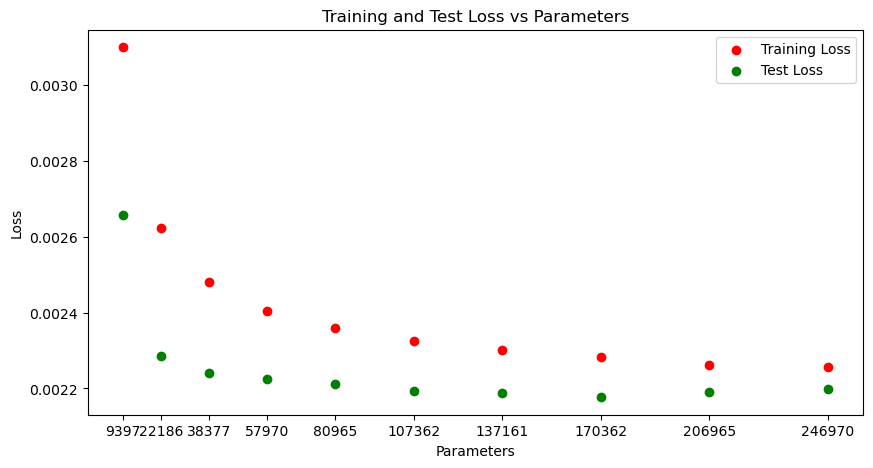

In [8]:
# Visualize Loss
plt.figure(figsize=(10, 5))
plt.scatter(params_arr, train_loss_arr, color="red")
plt.scatter(params_arr, test_loss_arr, color="green")
plt.xticks(params_arr, params_arr)
plt.legend(['Training Loss', 'Test Loss'])
plt.title('Training and Test Loss vs Parameters')
plt.xlabel('Parameters')
plt.ylabel('Loss')
plt.show()


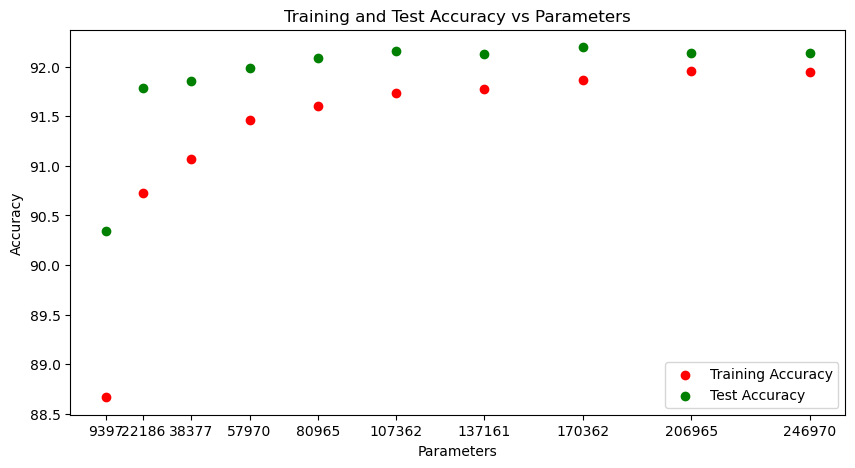

In [11]:
# Visualize acc
plt.figure(figsize=(10, 5))
plt.scatter(params_arr, train_acc_arr, color="red")
plt.scatter(params_arr, test_acc_arr, color="green")
plt.xticks(params_arr, params_arr)
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.title('Training and Test Accuracy vs Parameters')
plt.xlabel('Parameters')
plt.ylabel('Accuracy')
plt.show()
